In [ ]:
import numpy as np
import cupy as cp
import tensorflow as tf
from dataset import load_mnist

# Load Dataset

In [ ]:
x_train, x_test, y_train, y_test = load_mnist()


# Define neural network inputnoutput
input_size = x_train.shape[1]
output_size = y_train.shape[1]

print(x_train.shape,
x_test.shape,
y_train.shape,
y_test.shape)

# Experimento FP32

In [ ]:
# this is just for working with notebooks and classes outside the scope
# import importlib
# import NeuralNetwork
# import Activations
# importlib.reload(NeuralNetwork)
# importlib.reload(Activations)
# NeuralNetwork = NeuralNetwork.NeuralNetwork
########################################################################

import NeuralNetwork
NeuralNetwork = NeuralNetwork.NeuralNetwork


# Create and train the neural network
neural_network = NeuralNetwork(input_size, output_size)

In [ ]:
neural_network.train(x_train, y_train, learning_rate=0.001, num_epochs=3, batch_size=64)

# Make predictions on the test set
y_pred = neural_network.predict(x_test)

# Calculate accuracy
accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100}%")

# Teste de normalização de pesos e ativações durante treinamento

In [ ]:
# this is just for working with notebooks and classes outside the scope
import importlib
import NeuralNetwork
import Activations
import FullyConnectedLayer
importlib.reload(NeuralNetwork)
importlib.reload(Activations)
importlib.reload(FullyConnectedLayer)
NeuralNetworkWithScale = NeuralNetwork.NeuralNetworkWithScale
########################################################################

NeuralNetworkWithScale = NeuralNetwork.NeuralNetworkWithScale

# Create and train the neural network
neural_network_with_scale = NeuralNetworkWithScale(input_size, output_size)

### Loop de treinamento aqui

In [ ]:
neural_network_with_scale.train(x_train, y_train, learning_rate=0.001, num_epochs=10, batch_size=64)

# Make predictions on the test set
y_pred = neural_network_with_scale.predict(x_test)

# Calculate accuracy
accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100}%")

# Teste de normalização dos erros retropropagados

In [ ]:
# this is just for working with notebooks and classes outside the scope
import importlib
import NeuralNetwork
import Activations
import FullyConnectedLayer
importlib.reload(NeuralNetwork)
importlib.reload(Activations)
importlib.reload(FullyConnectedLayer)
NeuralNetworkWithScale = NeuralNetwork.NeuralNetworkWithScale
########################################################################

NeuralNetworkWithScale = NeuralNetwork.NeuralNetworkWithScale

# Create and train the neural network
neural_network_with_scale = NeuralNetworkWithScale(input_size, output_size)

In [ ]:
# descrever loop de treinamento aqui


inputs = x_train
targets = y_train
learning_rate = 0.001
num_epochs = 10
batch_size = 64



for epoch in range(num_epochs):
    loss = 0.0
    for batch_inputs, y_true in neural_network_with_scale.get_batches(inputs, targets, batch_size):
        
        # Forward pass
        z = neural_network_with_scale.forward(batch_inputs)

        # apply softmax
        y_pred = neural_network_with_scale.softmax.forward(z)

        # Compute loss
        loss += neural_network_with_scale.cross_entropy_loss_with_logits(y_pred, y_true)
        
        # Compute the derivative of the loss
        dz = neural_network_with_scale.cross_entropy_loss_with_logits_derivative(y_pred, y_true)
        

        #####################################
        # backward pass
        grad_output = dz
        

        # normalized gradients
        grad_output_scale = np.max(np.abs(grad_output))               

        # faz essa multiplicação para padronizar operações de retropropagação nas camadas
        grad_output = grad_output * neural_network_with_scale.layers[-1].output_scale / grad_output_scale

        for layer in reversed(neural_network_with_scale.layers):
            if isinstance(layer, FullyConnectedLayer.FullyConnectedLayerWithScale):
                grad_output = layer.backward_with_scale(grad_output, grad_output_scale, learning_rate)
                grad_output_scale = layer.grad_output_scale                

            else:
                grad_output = layer.backward(grad_output, learning_rate)
        #####################################

    loss /= len(inputs)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")


In [ ]:
# Make predictions on the test set
y_pred = neural_network_with_scale.predict(x_test)

# Calculate accuracy
accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100}%")

# Teste de quantização dos pesos e ativações

In [1]:
import numpy as np
import cupy as cp
import tensorflow as tf
from dataset import load_mnist
from NeuralNetwork import QNeuralNetworkWithScale
import Activations
import FullyConnectedLayer


# load dataset
x_train, x_test, y_train, y_test = load_mnist()

# Define neural network inputnoutput
input_size = x_train.shape[1]
output_size = y_train.shape[1]

print(x_train.shape,
x_test.shape,
y_train.shape,
y_test.shape)

# Create and train the neural network
neural_network_with_scale = QNeuralNetworkWithScale(input_size, output_size)

# train the nn
#neural_network_with_scale.train(x_train, y_train, learning_rate=0.000001, num_epochs=1, batch_size=256, x_val=x_test, y_val=y_test)
neural_network_with_scale.train(x_train, y_train, learning_rate=0.000010, num_epochs=1, batch_size=256, x_val=x_test, y_val=y_test)
neural_network_with_scale.train(x_train, y_train, learning_rate=0.000100, num_epochs=20, batch_size=256, x_val=x_test, y_val=y_test)
neural_network_with_scale.train(x_train, y_train, learning_rate=0.000010, num_epochs=5, batch_size=256, x_val=x_test, y_val=y_test)
# neural_network_with_scale.train(x_train, y_train, learning_rate=0.001000, num_epochs=7, batch_size=64, x_val=x_test, y_val=y_test)


(60000, 784) (10000, 784) (60000, 10) (10000, 10)
Epoch 1/1, Loss: 0.007696302057178959 Accuracy: 45.49%
Epoch 1/20, Loss: 0.008973539434650587 Accuracy: 36.7%
Epoch 2/20, Loss: 0.009948094835508793 Accuracy: 84.34%
Epoch 3/20, Loss: 0.0035005097014938723 Accuracy: 82.89%
Epoch 4/20, Loss: 0.003383381020309036 Accuracy: 89.92999999999999%
Epoch 5/20, Loss: 0.003078764600941686 Accuracy: 91.66%
Epoch 6/20, Loss: 0.0021245847310827396 Accuracy: 92.02%
Epoch 7/20, Loss: 0.0019055859702584795 Accuracy: 93.39%
Epoch 8/20, Loss: 0.002137555729957489 Accuracy: 93.04%
Epoch 9/20, Loss: 0.001926899308710018 Accuracy: 93.66%
Epoch 10/20, Loss: 0.0017133009366262267 Accuracy: 94.25%
Epoch 11/20, Loss: 0.0015784685623407065 Accuracy: 93.56%
Epoch 12/20, Loss: 0.0015975644286798597 Accuracy: 95.08%
Epoch 13/20, Loss: 0.0016276688080797644 Accuracy: 93.88%
Epoch 14/20, Loss: 0.0016206952582971778 Accuracy: 94.91000000000001%
Epoch 15/20, Loss: 0.001590570073718894 Accuracy: 95.1%
Epoch 16/20, Loss: 

# plot scales history

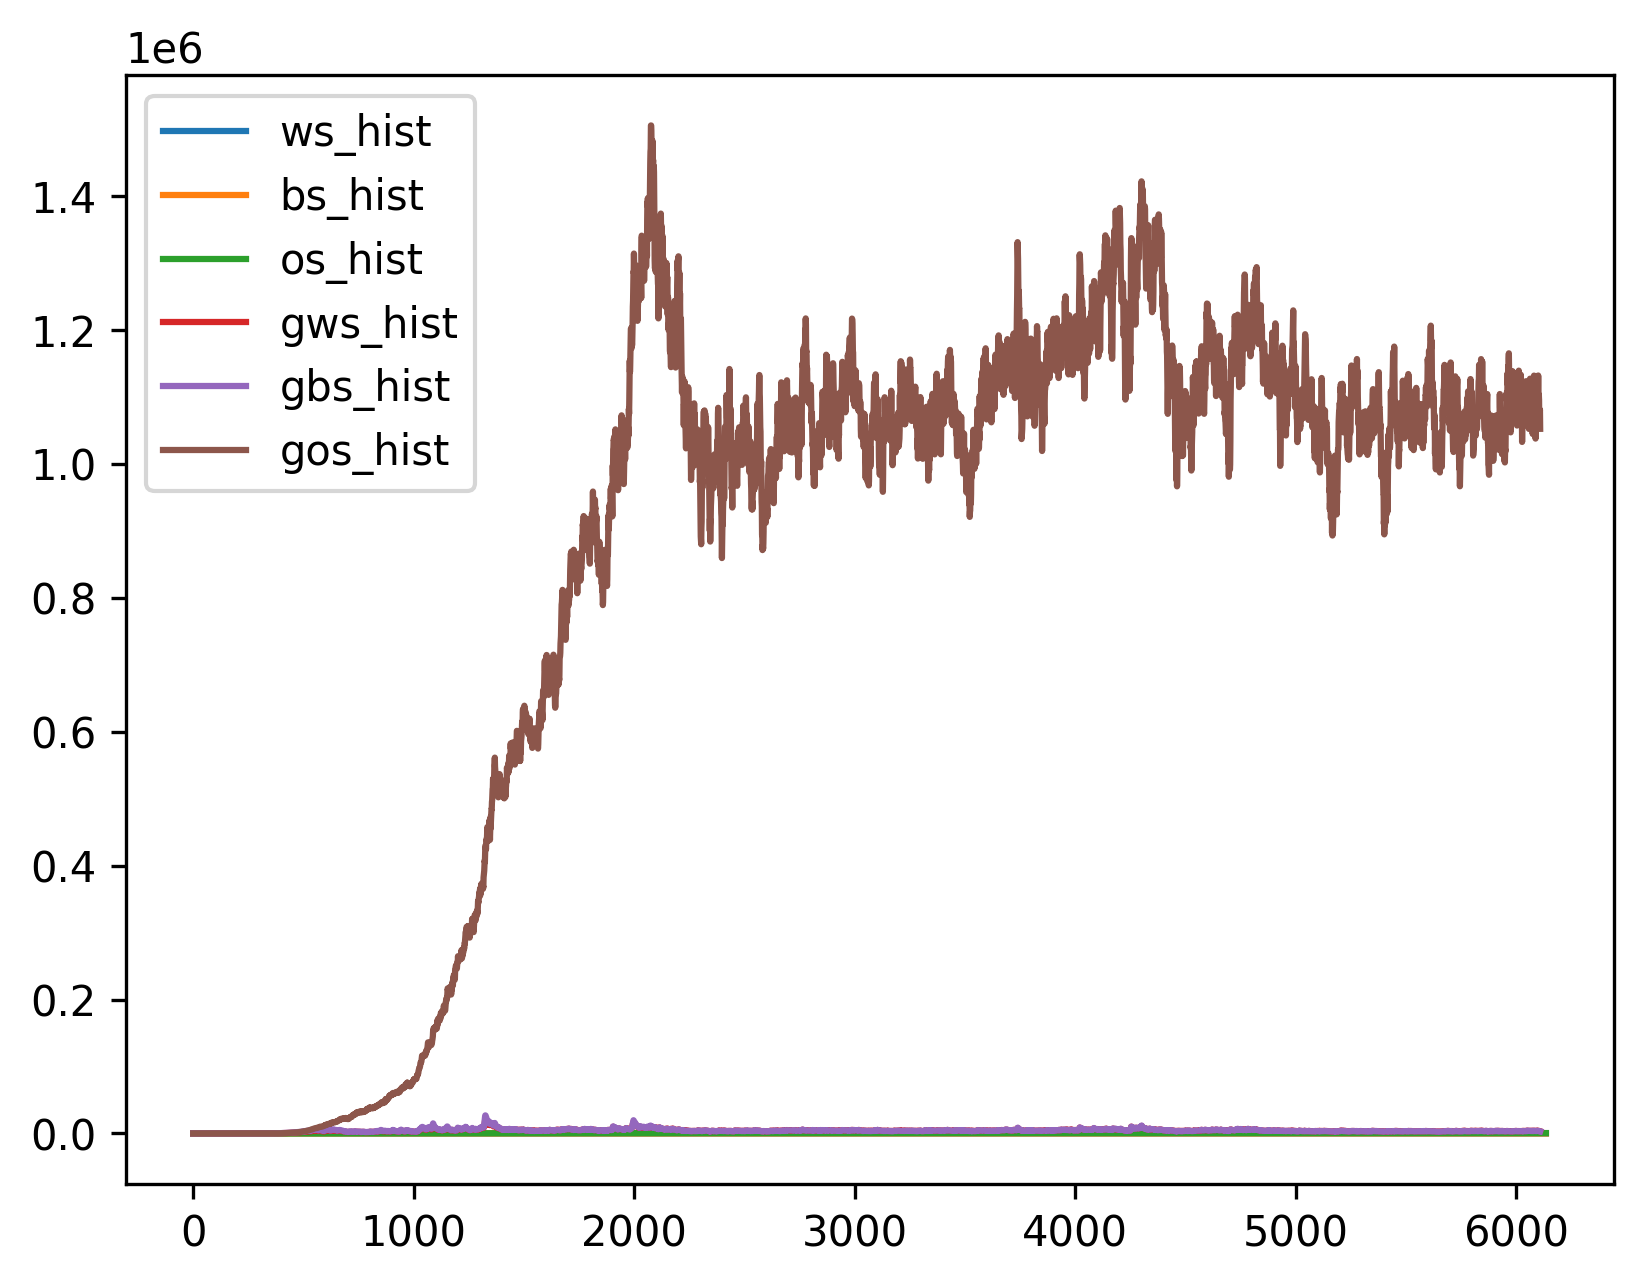

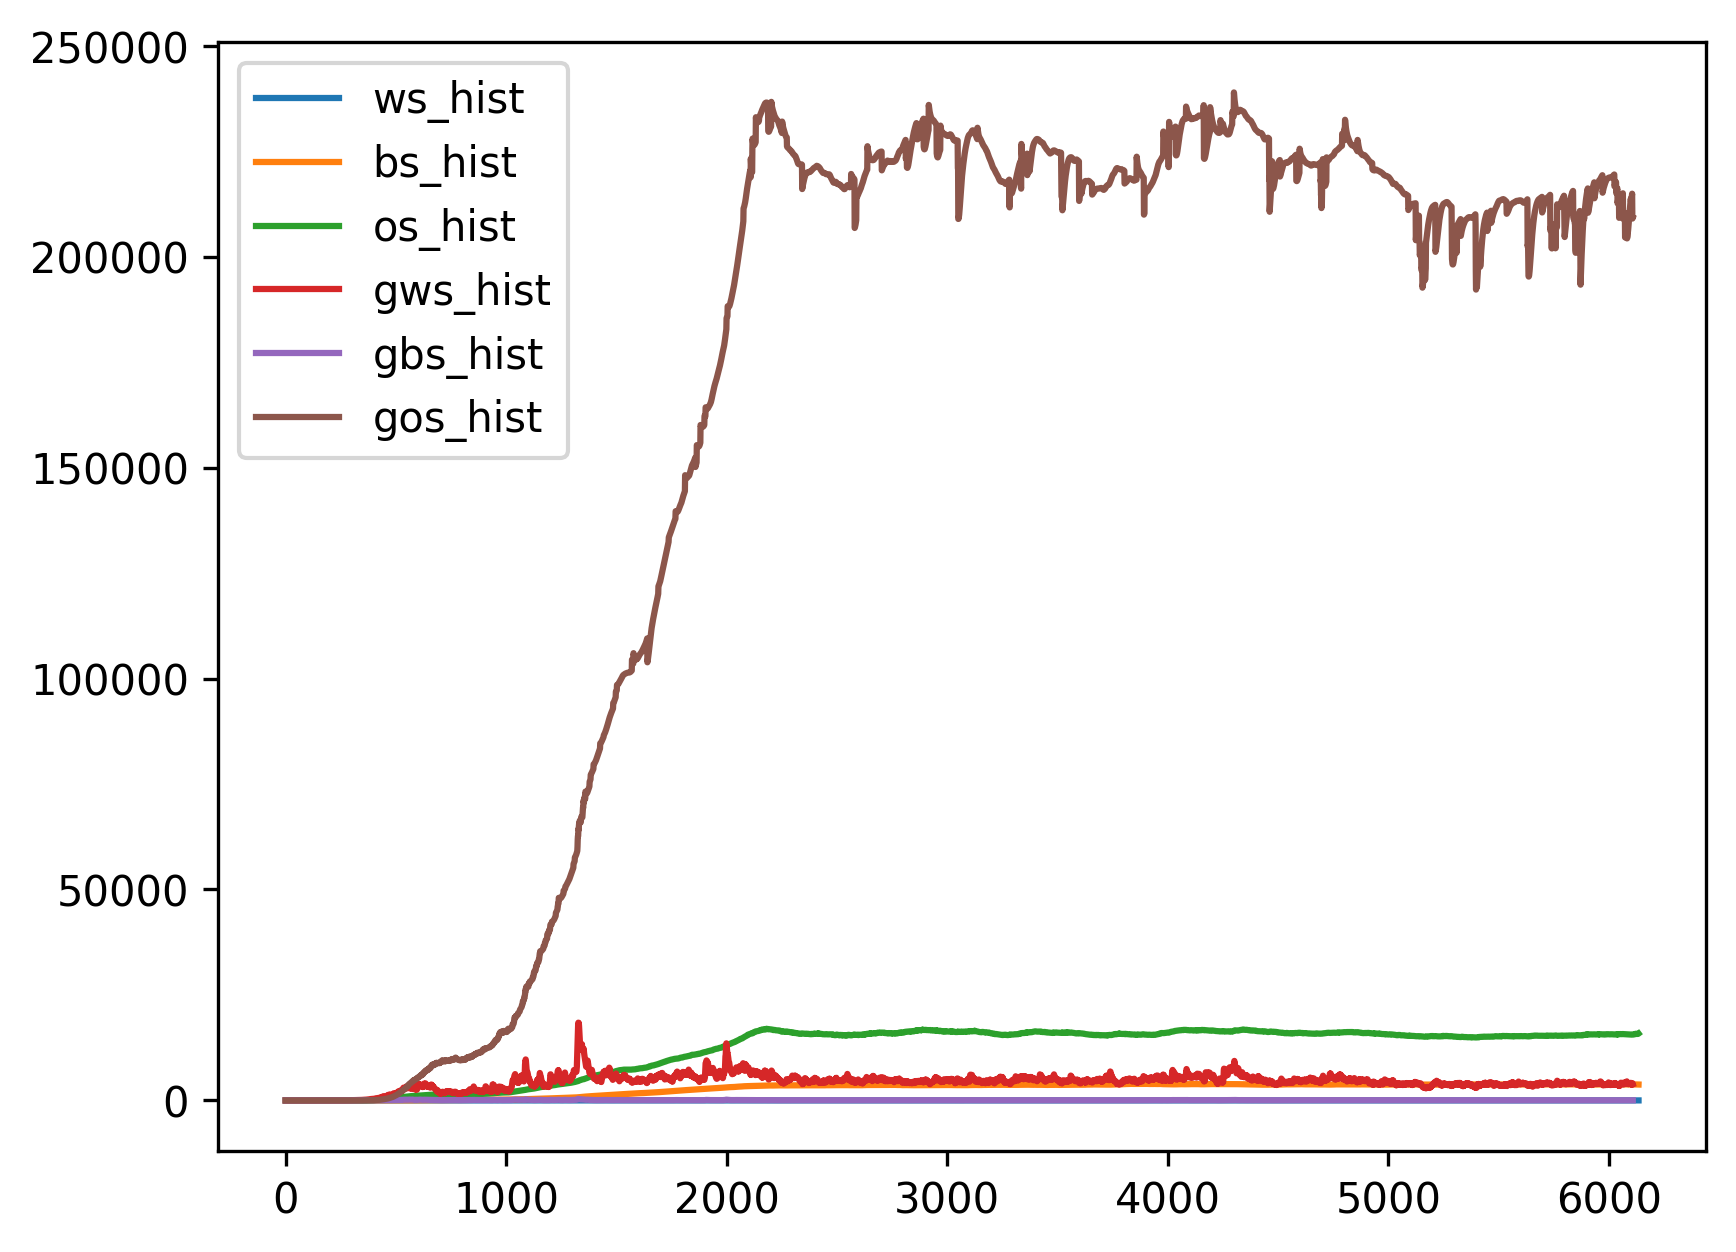

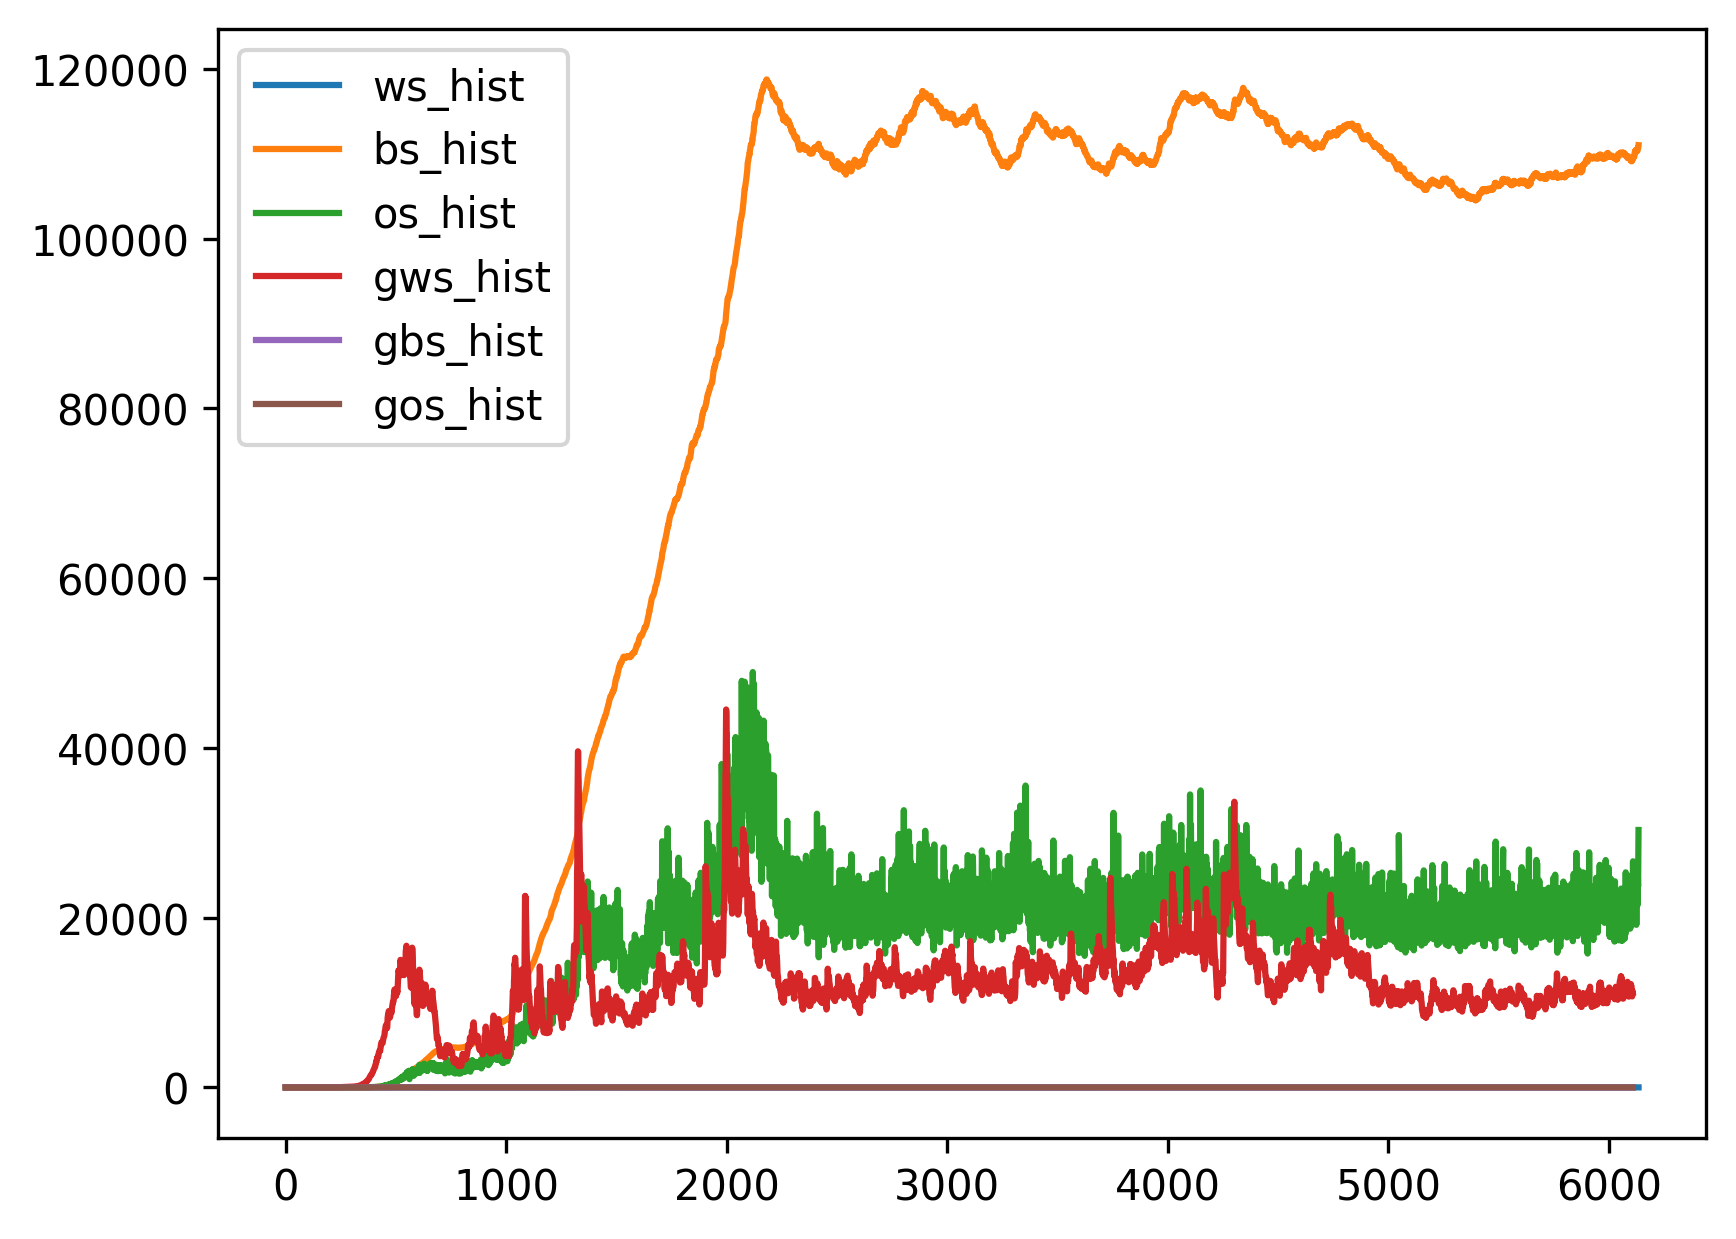

In [3]:
import matplotlib.pyplot as plt



for i, layer in enumerate(neural_network_with_scale.layers):
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):
        plt.figure(dpi=300)
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.ws_hist)), 0, 10))
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.bs_hist)), 0, 2000000))
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.os_hist)), 0, 2000000))
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.gws_hist)), 0, 2000000))
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.gbs_hist)), 0, 2000000))
        plt.plot(np.clip(cp.asnumpy(cp.array(layer.gos_hist)), 0, 2000000))
        
        leg = [ "ws_hist",
                 "bs_hist",
                 "os_hist",
                 "gws_hist",
                 "gbs_hist",
                 "gos_hist"
         ]
             
             
        plt.legend(leg)
        plt.show()
        
        

# plot grad histogram history

In [ ]:
for l, layer in enumerate(neural_network_with_scale.layers):
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):
        idx = []
        for i, g in enumerate(layer.grad_output_hist):
            if g.shape[0] != 256:
                idx.append(i)
        
        for i, id in enumerate(idx):
            layer.grad_output_hist.pop(id-i)
            
        np.save(f"layer{l}_grad_hist", np.array(layer.grad_output_hist, np.float32))

In [ ]:
import matplotlib.pyplot as plt

# plot grad history
for l, layer in enumerate(neural_network_with_scale.layers):
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):
        g = layer.grad_output_hist
        shape = g[0].shape

        # Criação dos dados
        z = np.array(g, np.float32)
        
        # Criação da figura e do eixo 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Coordenadas dos pontos no espaço 3D
        x, y, z = np.meshgrid(np.arange(z.shape[0]), np.arange(z.shape[1]), np.arange(z.shape[2]))

        # Plotagem do array 3D
        ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=z.ravel())

        # Configuração dos rótulos dos eixos
        ax.set_xlabel('Eixo X')
        ax.set_ylabel('Eixo Y')
        ax.set_zlabel('Eixo Z')

        # Exibição do gráfico
        plt.show()      




# plot wandb distributions

In [ ]:
import matplotlib.pyplot as plt



for i, layer in enumerate(neural_network_with_scale.layers):
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):

        plt.hist(np.ravel(cp.asnumpy(layer.weights)), bins=16)
        #plt.hist(np.ravel(cp.asnumpy(layer.biases)), bins=16)
        
        plt.show()
        
        

# plot output dist

In [ ]:
import matplotlib.pyplot as plt



for i, layer in enumerate(neural_network_with_scale.layers):
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):

        plt.hist(np.ravel(cp.asnumpy(layer.output)), bins=16)
                
        plt.show()
        

# calculate accuracy

In [ ]:
y_pred = neural_network_with_scale.predict(x_train, 256)

# Calculate accuracy
accuracy = cp.mean(y_pred == cp.argmax(y_train, axis=1))
print(f"Accuracy: {accuracy * 100}%")

In [ ]:
# validation
z = neural_network_with_scale.forward(x_test)
y_pred = cp.argmax(z, axis=-1)

# Calculate accuracy
accuracy = cp.mean(y_pred == cp.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100}%")

In [ ]:
import matplotlib.pyplot as plt
from quantizer import quantize
import copy 
## printing weight distribution


for layer in neural_network_with_scale.layers:
    if isinstance(layer, FullyConnectedLayer.QFullyConnectedLayerWithScale):
        w = copy.deepcopy(layer.weights)
        b = copy.deepcopy(layer.biases)
        o = copy.deepcopy(layer.output)
        
        
        # Initialise the subplot function using number of rows and columns
        figure, axis = plt.subplots(1, 3, figsize=(20,7))
        
        # For Sine Function
        axis[0].hist(cp.ravel(w), bins=160)
        axis[0].set_title("Float Weights")
        
        scale = cp.max(cp.abs(w))
        print(scale)

        w /= scale
        w = quantize(w, True)

        axis[1].hist(cp.ravel(w), bins=16)
        axis[1].set_title("Quantized Weights")
        
        axis[2].hist(cp.ravel(o), bins=16)
        axis[2].set_title("quantized outputs")

        plt.show()